<a href="https://colab.research.google.com/github/moritzgeiger/portfolio/blob/main/Count_metal_sheets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Counting Metal Sheets with CNN Methods -Part II- <a class='tocSkip'>"

**Contributors**: Moritz Geiger

# Imports & Intro

In [1]:
# !git clone https://github.com/moritzgeiger/sheet-counter.git
! pip install cloudinary --quiet
! pip install python-dotenv --quiet

     |████████████████████████████████| 174kB 11.9MB/s 


In [2]:
# TABULAR
import pandas as pd
import numpy as np

# FILES
from io import StringIO, BytesIO
import os
from shutil import copyfile
import re

# VIS
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
import seaborn as sns

# CLOUD
import cloudinary
from dotenv import load_dotenv, find_dotenv
from urllib.parse import urljoin
import requests

# MODEL
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from google.colab import files
from google.colab import drive


In [3]:
# API KEY CLOUDINARY
drive.mount('/content/drive')
load_dotenv(find_dotenv('/content/drive/MyDrive/sheet_count/.env'))
CLD = os.environ.get("CLD")
CLD_SECRET = os.environ.get("CLD_SECRET")

Mounted at /content/drive


## Introduction

This notebook explores options to build a model that counts metal sheets through image recognition. The goal is to have a service that returns the amount of metal sheets in an image. 

The images provided in the data set come from a production site and were taken with a phone camera in different angles and light shades. 

All images had to be labeled with the target count manually. They were then uploaded to a [cloudinary storage](#Upoading-all-images-to-cloudinary). 

## Sources

- Paper about counting from air (trees, cars): [https://arxiv.org/pdf/2102.04366v1.pdf](https://arxiv.org/pdf/2102.04366v1.pdf)
- more info on regression based methods: [https://arxiv.org/pdf/2007.01899v2.pdf](https://arxiv.org/pdf/2007.01899v2.pdf)
- basic model to count fingers: [https://analyticsindiamag.com/how-to-implement-cnn-model-to-count-fingers-and-distinguish-between-left-and-right-hand/](https://analyticsindiamag.com/how-to-implement-cnn-model-to-count-fingers-and-distinguish-between-left-and-right-hand/)
- How neural networks work: [https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480](https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480)
- load training dataset for rsoc: [https://github.com/gaoguangshuai/Counting-from-Sky-A-Large-scale-Dataset-for-Remote-Sensing-Object-Counting-and-A-Benchmark-Method](https://github.com/gaoguangshuai/Counting-from-Sky-A-Large-scale-Dataset-for-Remote-Sensing-Object-Counting-and-A-Benchmark-Method)
- Guide for CNN with pytorch: [https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce](https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce)

# Loading images

In [4]:
## load all filenames (FROM CLOUDINARY)
def cld_loader(folder,
                   api_key,
                   api_secret,
                   cloud_name='do59ghg7e'):
    """
    loads all file img urls from a given cloudinary folder.
    """
    
    result = cloudinary.Search().expression(f"folder:\"{folder}/*\"").execute(cloud_name=cloud_name,
                                                                              api_key=api_key,
                                                                              api_secret=api_secret,)
    existing_files = [x.get('filename') for x in result.get('resources')]
    print(f'found these images: \n{existing_files}')
    builder = f'https://res.cloudinary.com/do59ghg7e/image/upload/v1622549177/{folder}/'
    urls = {x:urljoin(builder, x) for x in existing_files}
    
    return urls
    
imgs = cld_loader(folder='sheet_imgs',
               api_key=CLD,
               api_secret=CLD_SECRET)

found these images: 
['1_00mm_16_21_fin', '1_5mm_8_69_fin', '1_0mm_1_81_fin', '1_5mm_0_109_fin', '0_75mm_3_159_fin', '1_5mm_46_51_fin', '1_2mm_4_48_fin', '1_5mm_4_120_fin', '0_75mm_0_175_fin', '1_00mm_29_91_fin', '1_00mm_21_129_fin', '1_5mm_25_36_fin', '1_5mm_43_53_fin', '1_00mm_39_56_fin', '1_5mm_2_120_fin', '1_00mm_33_109_fin', '1_2mm_0_55_fin', '1_5mm_48_94_fin', '1_2mm_5_62_fin', '1_5mm_32_23_fin', '1_00mm_8_58_fin', '1_0mm_0_89_fin', '1_00mm_26_123_fin', '1_0mm_6_3_fin', '1_5mm_33_74_fin', '1_5mm_40_52_fin', '1_5mm_5_120_fin', '1_00mm_1_124_fin', '1_5mm_35_56_fin', '1_5mm_23_36_fin', '1_00mm_28_80_fin', '1_5mm_50_97_fin', '1_00mm_20_21_fin', '1_5mm_49_103_fin', '1_5mm_26_36_fin', '1_5mm_18_75_fin', '1_5mm_31_105_fin', '1_5mm_12_58_fin', '1_00mm_43_159_fin', '1_5mm_9_84_fin', '1_5mm_51_98_fin', '1_00mm_17_23_fin', '1_2mm_6_61_fin', '1_2mm_3_60_fin', '1_00mm_61_92_fin', '1_2mm_2_59_fin', '1_00mm_42_154_fin', '1_2mm_1_63_fin', '1_00mm_49_96_fin', '1_00mm_22_110_fin']


**Note**<br>
The filenames have the following structure:<br>
```[thickness]_[id]_[sheetcount/target]_[<fin>].jpg```

In [5]:
print(f'The dataset consists of \033[1m{len(imgs)}\033[0m images. Some of which are not counted ("-99") due to blurryness. That might be of interest for further analysis.')
 

The dataset consists of 50 images. Some of which are not counted ("-99") due to blurryness. That might be of interest for further analysis.


# Exploring the dataset

The images show amateur photographs of metal sheet stacks on pallets in a warehouse during daylight conditions. The data provided contains metal sheets of sizes 0.75mm to 1.5mm. The sheets are either perforated or expanded. The perforated sheets lie horizontally on top of each other. The expanded metal forms a wavy profile when stacked.

## Examples

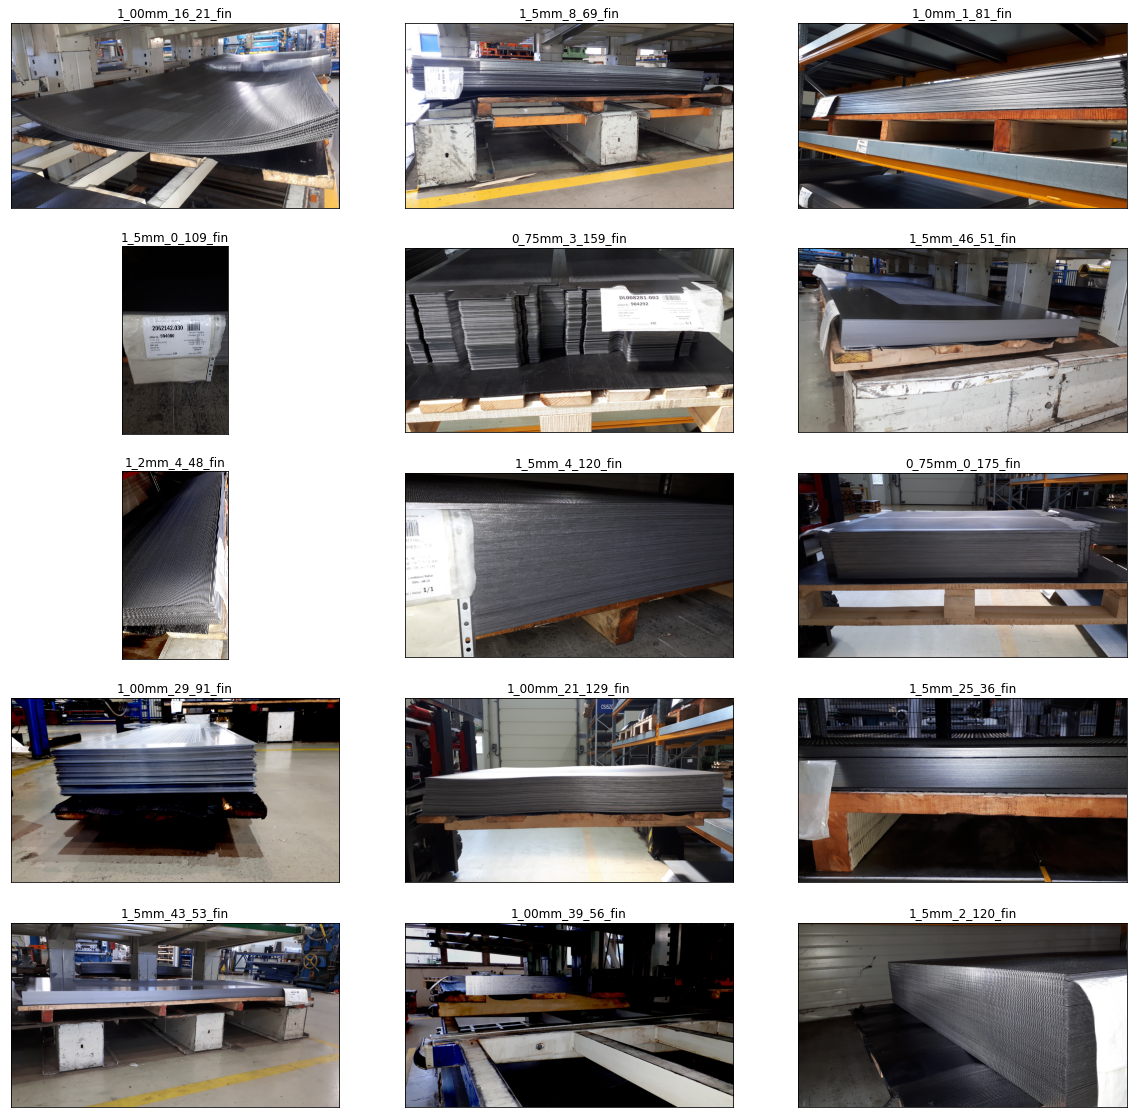

In [6]:
# showcasing some img examples
fig = plt.figure(figsize=(20,20))
for i in range(15):
    plt.subplot(5, 3, i+1)
    plt.title(f'img_{i}', size=12)
    plt.title(list(imgs.values())[i].split("/")[-1], size=12)
    im = requests.get(list(imgs.values())[i], stream=True).raw
    plt.imshow(mpimg.imread(im, format='jpeg'))
    plt.xticks(())
    plt.yticks(())

## Image quality

As visible, some of the images are not usable due to blurryness wrong angles. They would add too much noise to the model and will be manually sorted out of the data set. The optimal image should show the sheet stack from the side with enough light to detect the contrast between the sheets.
Note

The images are removed. They will be useful in case a decision/classifying layer should be implemented of whether to use an image or not. 

In [7]:
## find img resolutions
sizes = []
for img in list(imgs.values())[:1]:
    im = PIL.Image.open(requests.get(img, stream=True).raw)
    sizes.append(im.size)

In [8]:
# all images have the same resolution
print(f'The resolution of all images is: \033[1m{sizes[0][0]}x{sizes[0][1]}px\033[0m')

The resolution of all images is: 4608x2592px


## Cropped imgs

**Note**<br>
Looking at the upcoming steps it will be inevitable to crop the images to their most important part. This will be done manually, but can also be implemented later on in a subsequential automatized pre process.

In [9]:
# loading cropped images
cropped_imgs = cld_loader(folder='sheet_imgs/cropped',
                      api_key=CLD,
                      api_secret=CLD_SECRET)
# cropped_imgs

found these images: 
['1_00mm_16_21_fin', '1_5mm_8_69_fin', '1_0mm_1_81_fin', '1_5mm_0_109_fin', '0_75mm_3_159_fin', '1_5mm_46_51_fin', '1_2mm_4_48_fin', '1_5mm_4_120_fin', '0_75mm_0_175_fin', '1_00mm_29_91_fin', '1_00mm_21_129_fin', '1_5mm_25_36_fin', '1_5mm_43_53_fin', '1_00mm_39_56_fin', '1_5mm_2_120_fin', '1_00mm_33_109_fin', '1_2mm_0_55_fin', '1_5mm_48_94_fin', '1_2mm_5_62_fin', '1_5mm_32_23_fin', '1_00mm_8_58_fin', '1_0mm_0_89_fin', '1_00mm_26_123_fin', '1_0mm_6_3_fin', '1_5mm_33_74_fin', '1_5mm_40_52_fin', '1_5mm_5_120_fin', '1_00mm_1_124_fin', '1_5mm_35_56_fin', '1_5mm_23_36_fin', '1_00mm_28_80_fin', '1_5mm_50_97_fin', '1_00mm_20_21_fin', '1_5mm_49_103_fin', '1_5mm_26_36_fin', '1_5mm_18_75_fin', '1_5mm_31_105_fin', '1_5mm_12_58_fin', '1_00mm_43_159_fin', '1_5mm_9_84_fin', '1_5mm_51_98_fin', '1_00mm_17_23_fin', '1_2mm_6_61_fin', '1_2mm_3_60_fin', '1_00mm_61_92_fin', '1_2mm_2_59_fin', '1_00mm_42_154_fin', '1_2mm_1_63_fin', '1_00mm_49_96_fin', '1_00mm_22_110_fin']


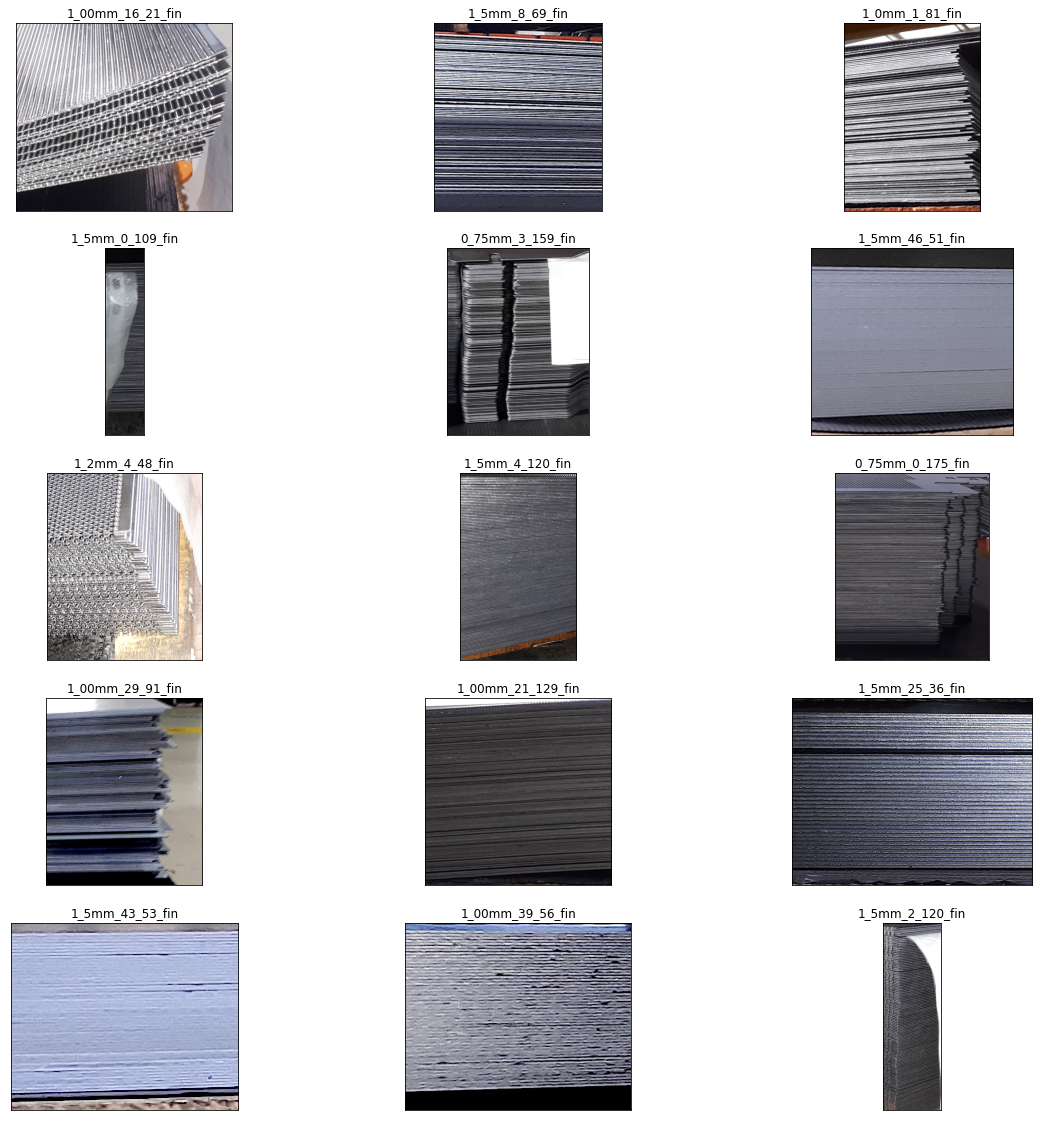

In [10]:
# showcasing some cropped img examples
fig = plt.figure(figsize=(20,20))
for i in range(15):
    plt.subplot(5, 3, i+1)
    plt.title(f'img_{i}', size=12)
    plt.title(list(cropped_imgs.values())[i].split("/")[-1], size=12)
    im = requests.get(list(cropped_imgs.values())[i], stream=True).raw
    plt.imshow(mpimg.imread(im, format='jpeg'))
    plt.xticks(())
    plt.yticks(())

## Target Range

In [11]:
## turning data into DF
img_dict = {'filepath':[],
            'thickness':[],
            'target':[],
           }
for name, img in cropped_imgs.items():
    splt = name.split('_')
    img_dict['filepath'].append(img)
    img_dict['thickness'].append(f'{splt[-5].split("/")[-1]}.{splt[-4]}')
    img_dict['target'].append(splt[-2])
    
img_df = pd.DataFrame(img_dict)
img_df['target'] = pd.to_numeric(img_df['target'])

In [12]:
# minor measurement cleaning
img_df['thickness'] = img_df['thickness'].replace({'1.0mm': '1.00mm'})

In [13]:
# showcase DF
img_df.sort_values(by='thickness', ascending=False).head(10)

filepath thickness  target
25  https://res.cloudinary.com/do59ghg7e/image/upl...     1.5mm      52
34  https://res.cloudinary.com/do59ghg7e/image/upl...     1.5mm      36
35  https://res.cloudinary.com/do59ghg7e/image/upl...     1.5mm      75
31  https://res.cloudinary.com/do59ghg7e/image/upl...     1.5mm      97
36  https://res.cloudinary.com/do59ghg7e/image/upl...     1.5mm     105
29  https://res.cloudinary.com/do59ghg7e/image/upl...     1.5mm      36
28  https://res.cloudinary.com/do59ghg7e/image/upl...     1.5mm      56
37  https://res.cloudinary.com/do59ghg7e/image/upl...     1.5mm      58
26  https://res.cloudinary.com/do59ghg7e/image/upl...     1.5mm     120
1   https://res.cloudinary.com/do59ghg7e/image/upl...     1.5mm      69

In [14]:
img_df.dtypes

filepath     object
thickness    object
target        int64
dtype: object

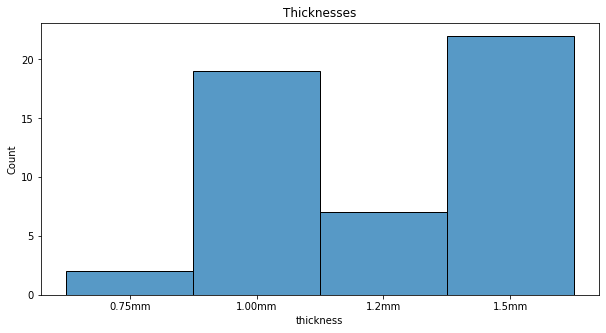

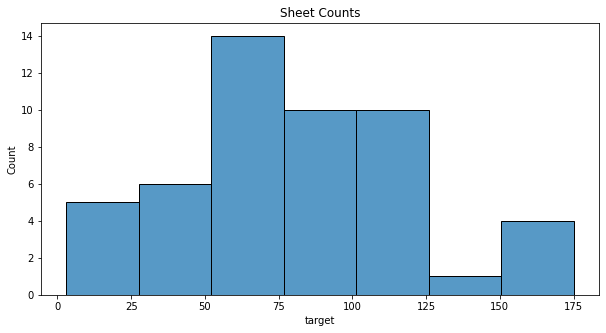

In [15]:
# distribution of dataset
plt.figure(1, figsize=(10,5))
plt.title('Thicknesses')
sns.histplot(data=img_df.thickness.sort_values())

plt.figure(2, figsize=(10,5))
plt.title('Sheet Counts')
sns.histplot(data=img_df.target.sort_values())

In [16]:
# Range of counts
img_df[img_df['target']>0].target.describe()

count     50.000000
mean      80.600000
std       39.494768
min        3.000000
25%       55.250000
50%       77.500000
75%      108.000000
max      175.000000
Name: target, dtype: float64

# IMG preprocessing

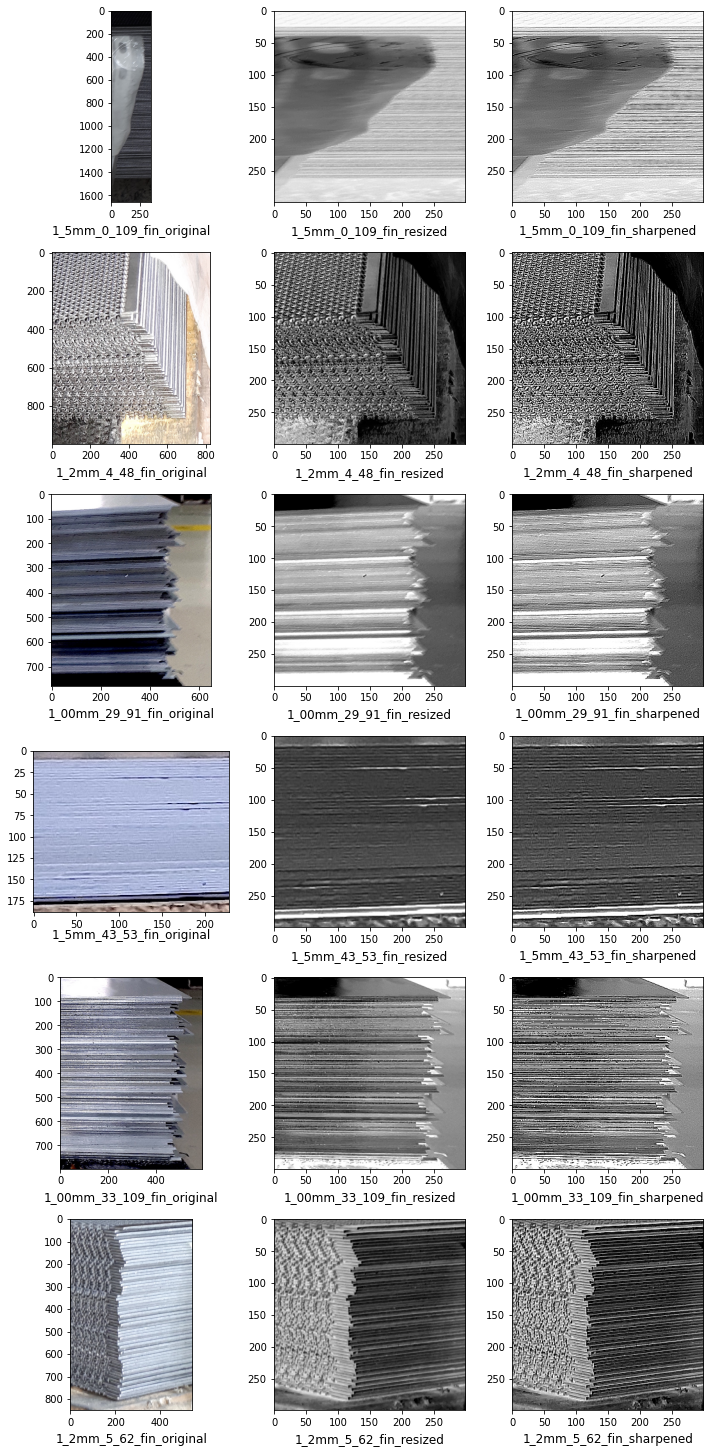

In [17]:
from PIL import ImageOps
from PIL import ImageFilter
# showcasing if resizing and grayscaling is possible
fig = plt.figure(figsize=(10,50))
# setting up 3 columns
for i in range(3,21,3):
    rem = requests.get(list(cropped_imgs.values())[i], stream=True).raw
    im = PIL.Image.open(rem)

    # without sharpening
    im = im.resize((300,300))
    im = ImageOps.grayscale(im)
    a = np.asarray(im)
    plt.subplot(15, 3, i-1)
    plt.title(f'{list(cropped_imgs.keys())[i]}_resized', size=12, y=-.2)
    plt.imshow(a, cmap=plt.cm.binary)

    # sharpening image 2x
    sharpened = im.filter(ImageFilter.SHARPEN)
    sharpened = sharpened.filter(ImageFilter.SHARPEN)
    sharpened = sharpened.resize((300,300))
    sharpened = ImageOps.grayscale(sharpened)
    b = np.asarray(sharpened)
    plt.subplot(15, 3, i)
    plt.title(f'{list(cropped_imgs.keys())[i]}_sharpened', size=12, y=-.2)
    plt.imshow(b, cmap=plt.cm.binary)

    # original
    plt.subplot(15, 3, i-2)
    plt.title(f'{list(cropped_imgs.keys())[i]}_original', size=12, y=-.2)
    plt.tight_layout()
    im = requests.get(list(cropped_imgs.values())[i], stream=True).raw
    plt.imshow(mpimg.imread(im, format='jpeg'))

**Note**<br>
It seems that resizing the images does not harm the images quality. It might even improve the readability of some images by expanding the countable layers graphically. Sharpening also adds contrast to the image. Therefore we will use it for further modelling.

In [18]:
# Applying resizing, grayscaling and encoding to all images in dataset
def resize_store(df):
    df_copy = df.copy()
    df_copy['imarray'] = None
    for c, row in df_copy.iterrows():
        path = row.filepath
        rem = requests.get(path, stream=True).raw
        im = PIL.Image.open(rem)
        sharpened = im.filter(PIL.ImageFilter.SHARPEN)
        sharpened = sharpened.filter(PIL.ImageFilter.SHARPEN)
        sharpened = sharpened.resize((300,300))
        sharpened = ImageOps.grayscale(sharpened)
        a = np.asarray(sharpened)
        df_copy.at[c, 'imarray'] = a
        # img_dict['imarray'].append()
    return df_copy

In [19]:
df_array = resize_store(img_df)

In [20]:
# checking for image sizes
print(set([i.shape for i in df_array.imarray]))

{(300, 300)}


In [21]:
np.dstack(df_array.imarray).shape

(300, 300, 50)

In [22]:
df_array.head()

filepath  ...                                            imarray
0  https://res.cloudinary.com/do59ghg7e/image/upl...  ...  [[210, 174, 182, 251, 227, 166, 172, 224, 255,...
1  https://res.cloudinary.com/do59ghg7e/image/upl...  ...  [[29, 29, 18, 28, 34, 27, 16, 28, 24, 24, 18, ...
2  https://res.cloudinary.com/do59ghg7e/image/upl...  ...  [[29, 31, 26, 29, 29, 26, 33, 25, 28, 30, 30, ...
3  https://res.cloudinary.com/do59ghg7e/image/upl...  ...  [[8, 10, 4, 2, 7, 12, 8, 8, 14, 15, 7, 6, 12, ...
4  https://res.cloudinary.com/do59ghg7e/image/upl...  ...  [[67, 63, 64, 76, 60, 47, 59, 57, 59, 58, 59, ...

[5 rows x 4 columns]

# Train test split

In [29]:
X = np.array(list(df_array.imarray))
y = np.array(df_array.target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [30]:
X_train.shape, X_test.shape

((33, 300, 300), (17, 300, 300))

In [28]:
# TODO:
## image augmentation / image generators / deep learning / cnn
## google keywords: identify straight lines image, e.g.
## find pretrained model for object counting
## check tensorflow image generator
## tensorflow object counting API
## increase black parts
## start kernels not randomly, but looking at stright lines
## use the classification-then-regression trick
# -> binning targets first, then train models per bin

# Model

In [31]:
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Dense, Reshape

In [32]:
#### 1. ARCHITECTURE
def small_cnn():

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(300, 300)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1))

    return model

# Regression
adam_opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)
model = small_cnn()
model.compile(loss='mse', 
              optimizer=adam_opt,
              metrics=['mae'])

es = callbacks.EarlyStopping(patience=30, restore_best_weights=True)

model.fit(X_train, y_train,
          batch_size=16, # Too small --> no generalization. Too large --> compute slowly
          epochs=100,
          validation_split=0.3,
          callbacks=[es],
          verbose=0)

ValueError: ignored

In [ ]:
print(model.evaluate(X_test, y_test))

In [ ]:
# [print(i.shape, i.dtype) for i in model.inputs]
# [print(o.shape, o.dtype) for o in model.outputs]
# [print(l.name, l.input_shape, l.dtype) for l in model.layers]

# Appendix

## Upoading all images to cloudinary

In [ ]:
## load all filenames (COLAB SPECIFIC)
newpath = '../sheet-counter/raw_data/finals'
final_imgs = [os.path.join(newpath, img) for img in os.listdir(newpath) if img.endswith('.jpg') and '-99' not in img]
# final_imgs

In [ ]:
from cloudinary import uploader
def cld_uploader(srcs, 
             folder,
             api_key,
             api_secret,
             cloud_name='do59ghg7e',
             overwrite=False):
    """
    uploads all files from a paths list. No overwriting by default.
    """
    
    result = cloudinary.Search().expression(f"folder:\"{folder}/*\"").execute(cloud_name=cloud_name,
                                                                              api_key=api_key,
                                                                              api_secret=api_secret,)

    existing_files = [x.get('filename') for x in result.get('resources')]

    for img in srcs:
        name = img.split('/')[-1]
        if name in existing_files:
            print(f'{name} already exists.')
        
        else:
            uploader.upload(img, 
                        folder = f"{folder}/", 
                        cloud_name='do59ghg7e',
                        public_id=name.replace('.jpg', ''), # file extension done automatically
                        api_key=CLD,
                        api_secret=CLD_SECRET,
                        use_filename=1, 
                        unique_filename=1)
            print(f'uploaded {name}')
          

In [ ]:
# uploading originals  
cld_uploader(final_imgs, 
         folder='sheet_imgs',
         api_key=CLD,
         api_secret=CLD_SECRET)
        

## Loading cropped imgs to cloudinary

In [ ]:
## load all filenames (COLAB SPECIFIC)
newpath = '../sheet-counter/raw_data/cropped'
cropped = [os.path.join(newpath, img) for img in os.listdir(newpath) if img.endswith('.jpg') and '-99' not in img]

# final_imgs
cld_uploader(cropped, 
         folder='sheet_imgs/cropped',
         api_key=CLD,
         api_secret=CLD_SECRET)